In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, load_iris
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram

# A helper function that you don't need to modify
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

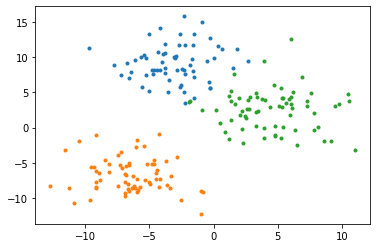

In [2]:
# Desired number of clusters
n_clusters = 3

# Maximum allowed cluster distortion. Feel free to adapt based on your distortion metric.
max_distortion = 100.0

# Maximum allowed number of iterations. Feel free to adapt
max_iter = 500

# Dataset generation
n_samples = 200
n_features = 2
X, y = make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    centers=n_clusters,
    cluster_std=2.75,
    random_state=42
)

# Create random initial mean vector 
mu = np.random.random((n_clusters, n_features))

# Initialize a label vector for point to cluster membership
labels = np.zeros(X.shape[0])

distortion = np.inf
iter = 0
while distortion > max_distortion and iter < max_iter:
    
    # Expectation step: For each data point, find closest class and label it.
    for i in range(X.shape[0]):
        dists = np.linalg.norm(mu - X[i,:], axis=1)
        cluster_id = np.argmin(dists)
        # assign cluster label to point i
        labels[i] = cluster_id

    # Maximization step: From current clusters, update mean vectors
    for i in range(mu.shape[0]):
        mu[i,:] = np.mean(X[labels == i,:], axis=0)

    # Calculate the total distortion
    distortion = 0
    for i in range(mu.shape[0]):
        # get all indices that belong to this cluster
        curr_clust_labels = labels == i
        # compute distortion, e.g. by euclidean distance
        distortion += np.linalg.norm(mu[i,:] - X[curr_clust_labels,:])
    # increase iteration counter
    iter += 1
    if iter == max_iter:
        print("Did not converge in maximum number of iterations")

# Print the cluster assignment
for i in range(mu.shape[0]):
    curr_clust_labels = labels == i
    curr_clust = X[curr_clust_labels,:]
    plt.plot(*curr_clust.T, '.')


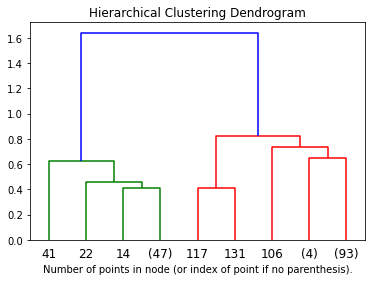

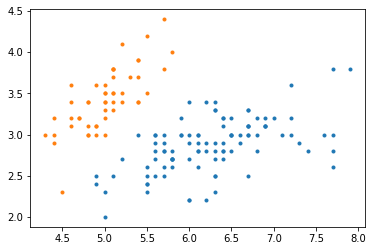

In [3]:
iris = load_iris() # Load the commonly known iris flower dataset
X = iris.data # Save the dataset in a matrix X

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='single')

model.fit(X) # fit the model with the data X
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


# Now, extract only three clusters from this dataset and view the result.
# Create a new model
model = AgglomerativeClustering(n_clusters=2, linkage='single')
model.fit(X) # fit the model with data X

# You can leave the plot code as it is
for i in range(max(model.labels_)+1):
    curr_cluster_indices = model.labels_ == i
    plt.plot(X[curr_cluster_indices, 0], X[curr_cluster_indices, 1], '.')
plt.show()


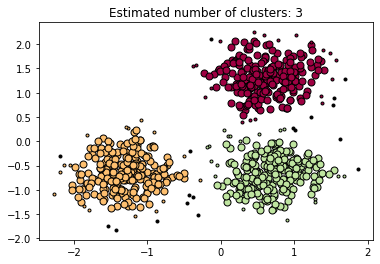

In [4]:
DENSITY_PARAMETER = 0.3

# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)

# Compute DBSCAN
db = DBSCAN(eps=DENSITY_PARAMETER, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Plot result
# Black is removed. It is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    class_member_mask = (labels == k)
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()